In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import string
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

SEED = 123
np.random.seed(SEED)

In [34]:
def load_reviews(file_name):
    f = open(file_name) 
    data = json.load(f)

    df_list = []
    for restaurant, reviews in data.items():
        normalized_df = pd.json_normalize(reviews)
        normalized_df['restaurant'] = restaurant
        df_list.append(normalized_df)

    return pd.concat(df_list, ignore_index=True)

reviews = []
path = "{}/reviews".format(os.getcwd())
for file_name in os.listdir(path):
    with open(path+'/'+file_name, "r") as json_file:
        reviews.append(load_reviews(path+'/'+file_name))
df_reviews = pd.concat(reviews, ignore_index=True)
    


In [35]:
df_reviews['photoCount'].fillna(0,inplace=True)
df_reviews.drop_duplicates()
df_reviews

,photoCount,reviewCount,eliteYear,localizedDate,rating,comment.text,comment.language,restaurant
0,1012.0,321.0,NaN,11/2/2018,5.0,*Tartinery is one of the food vendors at Hudso...,en,tartinery-new-york-15
1,190.0,1421.0,NaN,8/6/2023,3.0,Overall the service is very slow. We ordered 2...,en,tartinery-new-york-15
2,117.0,294.0,2023.0,10/17/2022,4.0,Yum I love a place that has interesting drinks...,en,tartinery-new-york-15
3,154.0,171.0,2023.0,11/29/2021,5.0,I always look for a comfortable go to bar/rest...,en,tartinery-new-york-15
4,6668.0,2143.0,2023.0,4/6/2022,3.0,Tartinery is where you go for happy hour wine ...,en,tartinery-new-york-15
...,...,...,...,...,...,...,...,...
331688,301.0,77.0,2023.0,5/21/2022,4.0,Great brunch spot. Cute decor. The coffee was ...,en,brownstone-pancake-factory-edgewater
331689,324.0,114.0,2023.0,10/1/2022,4.0,An &#34;All American Dinner&#34; that is affor...,en,brownstone-pancake-factory-edgewater
331690,24.0,10.0,NaN,9/10/2023,5.0,Went today and got the triple d buffalo chicke...,en,brownstone-pancake-factory-edgewater
331691,5.0,35.0,NaN,5/7/2023,5.0,We came to Brownstone as a group of 30 on a bu...,en,brownstone-pancake-factory-edgewater


In [36]:
df_reviews_stat = df_reviews[['restaurant', 'photoCount']].groupby('restaurant').count().rename(columns={'photoCount':'reviews_cnt'})
df_reviews_stat['elite_reviews_cnt'] = df_reviews[['restaurant', 'eliteYear']].groupby('restaurant').count()['eliteYear']
df_reviews_stat['elite_reviews_perc'] = df_reviews_stat['elite_reviews_cnt']/df_reviews_stat['reviews_cnt']
df_reviews_stat['user_photo_cnt_avg'] = df_reviews[['restaurant', 'photoCount']].groupby('restaurant').mean()['photoCount']
df_reviews_stat['user_review_cnt_avg'] = df_reviews[['restaurant', 'reviewCount']].groupby('restaurant').mean()['reviewCount']
df_reviews_stat['rating_avg'] = df_reviews[['restaurant', 'rating']].groupby('restaurant').mean()['rating']
df_reviews_stat['rating_med'] = df_reviews[['restaurant', 'rating']].groupby('restaurant').median()['rating']
df_reviews_stat['rating_std'] = df_reviews[['restaurant', 'rating']].groupby('restaurant').std()['rating']
df_reviews_stat
# df_reviews[['photoCount','reviewCount','eliteYear','rating','restaurant']].groupby('restaurant').aggregate([np.mean])

,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
restaurant,,,,,,,,
1-bite-mediterranean-new-york,17,1,0.058824,36.176471,134.588235,3.058824,3.0,1.344925
1-chimi-sushi-new-york,15,2,0.133333,1983.400000,525.933333,2.933333,3.0,1.533747
1-columbia-deli-new-york,5,0,0.000000,2.800000,9.200000,1.800000,1.0,1.788854
1-dollar-pizza-new-york,50,14,0.280000,816.540000,304.920000,3.440000,4.0,1.514016
1-minute-cafe-new-york-2,1,0,0.000000,0.000000,8.000000,2.000000,2.0,NaN
...,...,...,...,...,...,...,...,...
zzs-clam-bar-new-york,50,10,0.200000,633.340000,315.660000,4.260000,5.0,1.157231
çka-ka-qëllu-new-york-3,50,30,0.600000,740.680000,264.520000,4.520000,5.0,0.762381
épicerie-boulud-new-york-6,50,22,0.440000,910.640000,348.120000,3.760000,4.0,1.238168


In [37]:
def load_restaurant_data(file_name):
    f = open(file_name) 
    data = json.load(f)
    df_list = []
    for restaurant, info in data.items():
        normalized_df = pd.json_normalize(info)
        normalized_df['restaurant'] = restaurant
        df_list.append(normalized_df)

    # Concatenate all dataframes
    df_restaurants = pd.concat(df_list, ignore_index=True)
    return flatten_category(df_restaurants)


def extract_titles(row):
    # Extracting 'title' from each column if it is not None, otherwise using None
    return [row[i]['title'] if row[i] is not None else None for i in range(len(row))]

def flatten_category(df):
    new_category = pd.json_normalize(df['categories'])
    category_df = new_category.apply(extract_titles, axis=1, result_type='expand')

    # Renaming the columns
    category_df.columns = [f'category_{i}' for i in range(new_category.shape[1])]

    # Concatenate with the original dataframe if needed
    df = pd.concat([df, category_df], axis=1)
    return df


df_restaurants = load_restaurant_data('restaurants.json')
#df_restaurants2 = load_restaurant_data('restaurants2.json')
#df_restaurants = pd.concat([df_restaurants1,df_restaurants2], ignore_index=True)


In [38]:
michelin_dict = json.load(open("michelin_alias.json") )
df_restaurants['is_michelin'] = [1 if i in michelin_dict.values() else 0 for i in df_restaurants['restaurant']]

In [39]:
# exclude 8 brooklyn restaurants
'''
no_data_michelin_list = []
for j in michelin_dict.values():
    exist = 0
    for i in df_restaurants['restaurant']:
        if i == j:
            # print(i, "||", j)
            exist += 1
    if exist == 0:
        no_data_michelin_list.append(j)
no_data_michelin_list
'''

'\nno_data_michelin_list = []\nfor j in michelin_dict.values():\n    exist = 0\n    for i in df_restaurants[\'restaurant\']:\n        if i == j:\n            # print(i, "||", j)\n            exist += 1\n    if exist == 0:\n        no_data_michelin_list.append(j)\nno_data_michelin_list\n'

In [40]:

df_restaurants.head()



,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.zip_code,location.country,location.state,location.display_address,restaurant,category_0,category_1,category_2,category_3,is_michelin
0,ce605OMECZ3jLZtk6dCDHA,le-pain-quotidien-new-york-137,Le Pain Quotidien,https://s3-media3.fl.yelpcdn.com/bphoto/z-YqDX...,False,https://www.yelp.com/biz/le-pain-quotidien-new...,84,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",3.0,"[pickup, delivery]",...,10280,US,NY,"[395 S End Ave, New York, NY 10280]",le-pain-quotidien-new-york-137,Coffee & Tea,Bakeries,Breakfast & Brunch,None,0
1,B8yFj4qt-HgMCbF5S-GkgA,creperie-new-york-6,Creperie,https://s3-media1.fl.yelpcdn.com/bphoto/uydGkc...,False,https://www.yelp.com/biz/creperie-new-york-6?a...,19,"[{'alias': 'creperies', 'title': 'Creperies'}]",2.5,[],...,10281,US,NY,"[255 Liberty St, New York, NY 10281]",creperie-new-york-6,Creperies,None,None,None,0
2,WZLhPYaYSFy7M_-Jh1VuNw,dos-toros-taqueria-new-york-5,Dos Toros Taqueria,https://s3-media1.fl.yelpcdn.com/bphoto/fNdfBJ...,False,https://www.yelp.com/biz/dos-toros-taqueria-ne...,132,"[{'alias': 'mexican', 'title': 'Mexican'}]",3.5,[],...,10281,US,NY,"[225 Liberty St, Ste 242, New York, NY 10281]",dos-toros-taqueria-new-york-5,Mexican,None,None,None,0
3,tFQRwk9SVOFgpMBZ55UrLw,umami-burger-new-york-17,Umami Burger,https://s3-media2.fl.yelpcdn.com/bphoto/uvquI3...,False,https://www.yelp.com/biz/umami-burger-new-york...,333,"[{'alias': 'burgers', 'title': 'Burgers'}]",3.0,"[delivery, pickup]",...,10281,US,NY,"[225 Liberty St, Ste 247, New York, NY 10281]",umami-burger-new-york-17,Burgers,None,None,None,0
4,jhs35REmv8Yo9-Z27KQJSA,naya-brookfield-place-new-york-3,NAYA - Brookfield Place,https://s3-media3.fl.yelpcdn.com/bphoto/Zd6LgX...,False,https://www.yelp.com/biz/naya-brookfield-place...,32,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"[pickup, delivery]",...,10281,US,NY,"[225 Liberty St, Fl 2, New York, NY 10281]",naya-brookfield-place-new-york-3,Mediterranean,Lebanese,None,None,0


In [41]:
df_final = pd.merge(df_restaurants, df_reviews_stat, how='inner', on='restaurant')
df_final

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,category_3,is_michelin,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
0,ce605OMECZ3jLZtk6dCDHA,le-pain-quotidien-new-york-137,Le Pain Quotidien,https://s3-media3.fl.yelpcdn.com/bphoto/z-YqDX...,False,https://www.yelp.com/biz/le-pain-quotidien-new...,84,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",3.0,"[pickup, delivery]",...,None,0,50,16,0.320000,755.900000,199.860000,3.320000,4.0,1.531173
1,B8yFj4qt-HgMCbF5S-GkgA,creperie-new-york-6,Creperie,https://s3-media1.fl.yelpcdn.com/bphoto/uydGkc...,False,https://www.yelp.com/biz/creperie-new-york-6?a...,19,"[{'alias': 'creperies', 'title': 'Creperies'}]",2.5,[],...,None,0,19,1,0.052632,654.894737,244.842105,2.631579,2.0,1.300022
2,WZLhPYaYSFy7M_-Jh1VuNw,dos-toros-taqueria-new-york-5,Dos Toros Taqueria,https://s3-media1.fl.yelpcdn.com/bphoto/fNdfBJ...,False,https://www.yelp.com/biz/dos-toros-taqueria-ne...,132,"[{'alias': 'mexican', 'title': 'Mexican'}]",3.5,[],...,None,0,50,24,0.480000,3183.000000,365.740000,4.040000,4.0,1.159873
3,tFQRwk9SVOFgpMBZ55UrLw,umami-burger-new-york-17,Umami Burger,https://s3-media2.fl.yelpcdn.com/bphoto/uvquI3...,False,https://www.yelp.com/biz/umami-burger-new-york...,333,"[{'alias': 'burgers', 'title': 'Burgers'}]",3.0,"[delivery, pickup]",...,None,0,50,34,0.680000,941.800000,424.520000,3.240000,3.5,1.378553
4,jhs35REmv8Yo9-Z27KQJSA,naya-brookfield-place-new-york-3,NAYA - Brookfield Place,https://s3-media3.fl.yelpcdn.com/bphoto/Zd6LgX...,False,https://www.yelp.com/biz/naya-brookfield-place...,32,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"[pickup, delivery]",...,None,0,32,15,0.468750,603.875000,252.406250,4.250000,5.0,1.077632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10872,J0V2C6wAkHMLD9j7I50_ZQ,sgd-dubu-so-gong-dong-tofu-and-bbq-edgewater-2,SGD Dubu So Gong Dong Tofu & BBQ,https://s3-media3.fl.yelpcdn.com/bphoto/xX4DnY...,False,https://www.yelp.com/biz/sgd-dubu-so-gong-dong...,228,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",4.0,[delivery],...,None,0,50,28,0.560000,979.220000,312.580000,3.860000,4.0,1.143036
10873,awvl9pC0RW8PT5A3NeLGMg,fuxingmei-sushi-house-edgewater,FuXingMei Sushi House,https://s3-media1.fl.yelpcdn.com/bphoto/ZgikoA...,False,https://www.yelp.com/biz/fuxingmei-sushi-house...,94,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.0,"[delivery, pickup]",...,None,0,50,16,0.320000,609.660000,186.440000,4.000000,4.0,1.195229
10874,JmhZW6euOW_7L3E3v4fpKg,happy-wok-bronx,Happy Wok,,False,https://www.yelp.com/biz/happy-wok-bronx?adjus...,6,"[{'alias': 'chinese', 'title': 'Chinese'}]",2.0,"[delivery, pickup]",...,None,0,6,0,0.000000,1.833333,5.833333,2.166667,1.0,1.834848
10875,S55v4pq633nTz7jbGmrCfg,justins-pizza-bronx,Justin's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/CH79G2...,False,https://www.yelp.com/biz/justins-pizza-bronx?a...,18,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",2.5,"[delivery, pickup]",...,None,0,18,1,0.055556,3847.222222,312.888889,2.611111,2.0,1.685191


In [42]:
df_final.columns

Index(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count',
       'categories', 'rating', 'transactions', 'price', 'phone',
       'display_phone', 'distance', 'coordinates.latitude',
       'coordinates.longitude', 'location.address1', 'location.address2',
       'location.address3', 'location.city', 'location.zip_code',
       'location.country', 'location.state', 'location.display_address',
       'restaurant', 'category_0', 'category_1', 'category_2', 'category_3',
       'is_michelin', 'reviews_cnt', 'elite_reviews_cnt', 'elite_reviews_perc',
       'user_photo_cnt_avg', 'user_review_cnt_avg', 'rating_avg', 'rating_med',
       'rating_std'],
      dtype='object')

### Amelia's Part

[Amelia]
- Michelin vs Non-Michelin
- Significance testing
- Rating distribution
- reviews
- rating trend over time

Action Items    
Everyone: Standardizing functions, data source    
Julia -> geo maps, interesting visualizations (potentially heatmap by price/neighborhood?)    
Amelia -> classifier model, lighter visualizations (maybe cuisine distribution for Michelin vs non-Michelin)    
Will -> Functionalizing NLP code (subsetting data issue)    
Mariam -> thesis/light functional documentation for flow, Yelp Elite EDA & Michelin ratings, establish causation ()    
Noted Issues    
62 vs 63 restaurants for Michelin when dropping BK restaurants    
Other:    
line charts of ratings, volume, Yelp elites over time?    

## 0 Data Description

In [43]:
df_final.describe()

,review_count,rating,distance,is_michelin,reviews_cnt,elite_reviews_cnt,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_avg,rating_med,rating_std
count,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,9874.000000
mean,215.190953,3.637906,776.487108,0.005700,30.494897,11.410040,0.310402,1104.176772,256.831050,3.668073,3.902822,1.213507
std,496.119591,0.906646,504.724080,0.075287,20.740287,11.893697,0.256593,4119.449035,383.831461,0.899900,1.164432,0.445308
min,0.000000,0.000000,10.852661,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,7.000000,3.000000,422.643838,0.000000,7.000000,1.000000,0.100000,142.060000,105.750000,3.214286,3.500000,0.976039
50%,46.000000,4.000000,640.285639,0.000000,40.000000,7.000000,0.272727,454.000000,194.880000,3.880000,4.000000,1.253566
75%,220.000000,4.000000,992.022654,0.000000,50.000000,20.000000,0.480000,938.620000,298.280000,4.280000,5.000000,1.490644
max,15280.000000,5.000000,2726.565479,1.000000,50.000000,50.000000,1.000000,115226.000000,8462.000000,5.000000,5.000000,2.828427


/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/1320347723.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_final.corr()


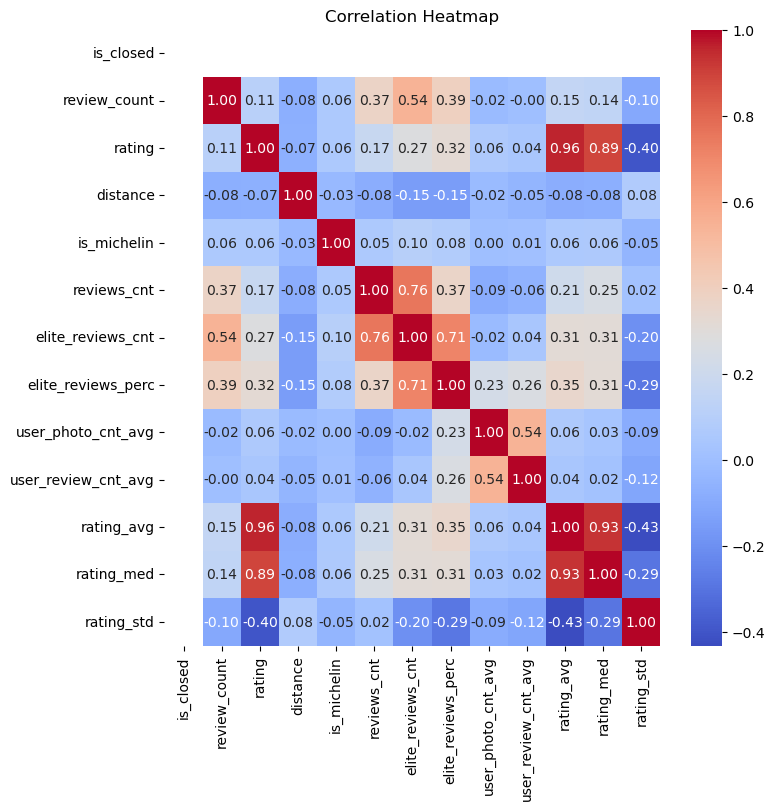

In [44]:
corr_matrix = df_final.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 1 Review Counts Distribution

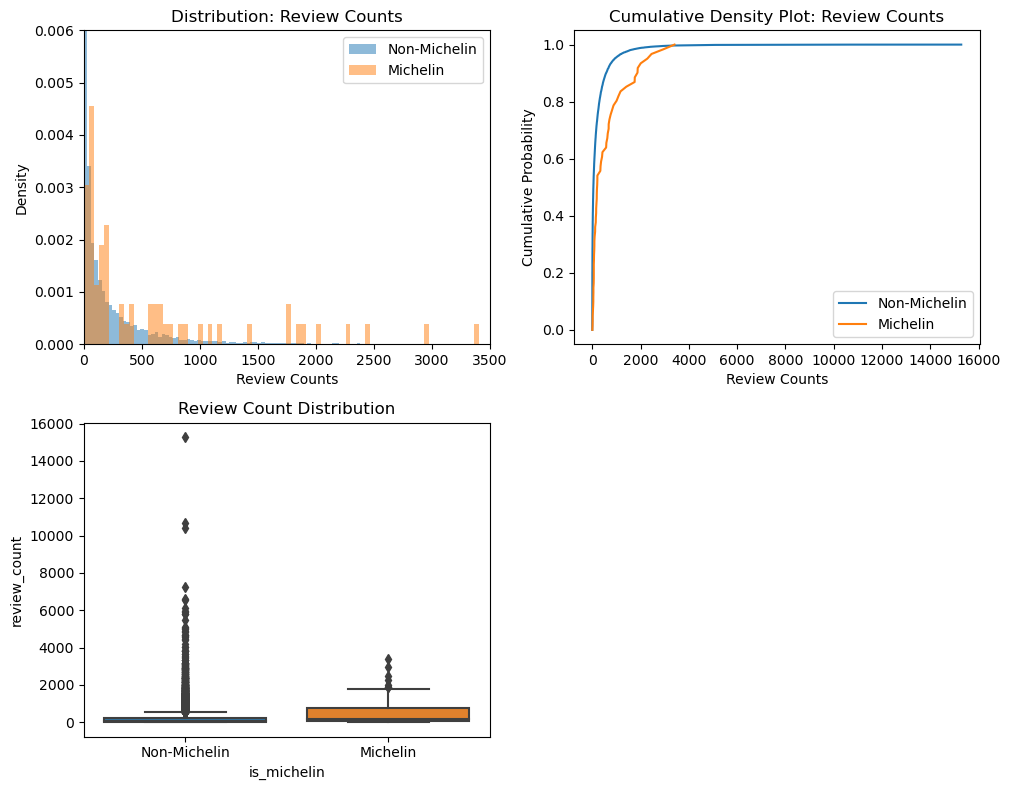

In [45]:
michelin_feature = df_final[df_final['is_michelin']==1]['review_count']
nonmichelin_feature = df_final[df_final['is_michelin']==0]['review_count']

plt.figure(figsize=(10, 8))


plt.subplot(2,2,1)
plt.hist(x = nonmichelin_feature, bins = 500, density = True, alpha=0.5, label = "Non-Michelin")
plt.hist(x = michelin_feature, bins = 80, density = True, alpha=0.5, label = "Michelin")
plt.xlim(0, 3500) # After 3500 the data is sparse so we just ignore that part for better visualization
plt.ylim(0, 0.006) # For density > 0.006 the data is sparse so we just ignore that part for better visualization
plt.ylabel("Density")
plt.xlabel("Review Counts")
plt.title("Distribution: Review Counts")
plt.legend()

plt.subplot(2,2,2)
sorted_michelin = np.sort(michelin_feature)
sorted_nonmichelin = np.sort(nonmichelin_feature)

# Calculate the cumulative distribution function (CDF)
cumulative_michelin = np.linspace(0, 1, len(sorted_michelin))
cumulative_nonmichelin = np.linspace(0, 1, len(sorted_nonmichelin))

# Plot the cumulative density
plt.plot(sorted_nonmichelin, cumulative_nonmichelin, label='Non-Michelin')
plt.plot(sorted_michelin, cumulative_michelin, label='Michelin')
plt.title('Cumulative Density Plot: Review Counts')
plt.xlabel('Review Counts')
plt.ylabel('Cumulative Probability')
plt.legend()


plt.subplot(2,2,3)
# plt.boxplot([michelin_feature, nonmichelin_feature], labels=['Michelin', 'Non-Michelin'])
sns.boxplot(x='is_michelin', y='review_count', data=df_final)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Review Count Distribution')

plt.tight_layout()
plt.show()


## 2 Elite Review Precentage Distribution

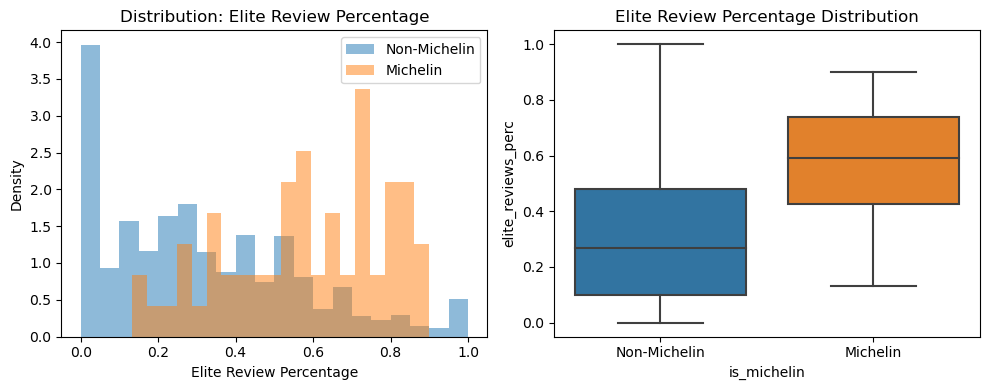

In [46]:
michelin_feature = df_final[df_final['is_michelin']==1]['elite_reviews_perc']
nonmichelin_feature = df_final[df_final['is_michelin']==0]['elite_reviews_perc']

plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.hist(x = nonmichelin_feature, bins = 20, density = True, alpha=0.5, label = "Non-Michelin")
plt.hist(x = michelin_feature, bins = 20, density = True, alpha=0.5, label = "Michelin")
plt.ylabel("Density")
plt.xlabel("Elite Review Percentage")
plt.title("Distribution: Elite Review Percentage")
plt.legend()

plt.subplot(1,2,2)
# plt.boxplot([michelin_feature, nonmichelin_feature], labels=['Michelin', 'Non-Michelin'])
sns.boxplot(x='is_michelin', y='elite_reviews_perc', data=df_final)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Elite Review Percentage Distribution')

plt.tight_layout()
plt.show()

## 3 Rating Distribution

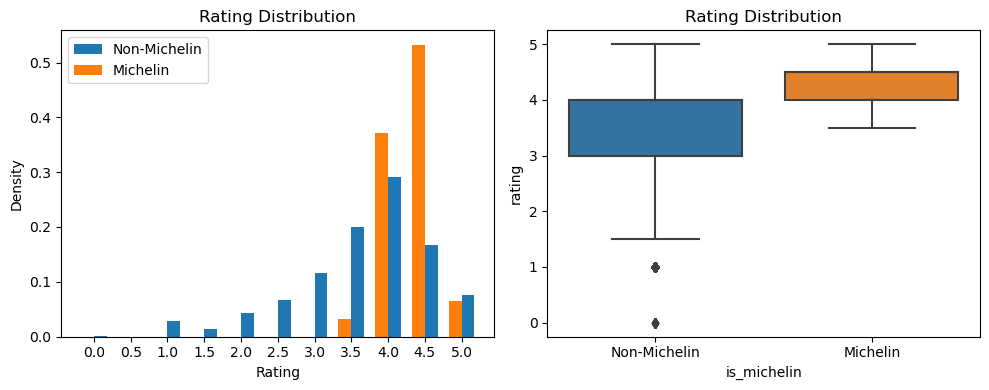

In [47]:
labels = np.arange(0, 5.5, 0.5)
bar_width = 0.35
# Positions of bars on the x-axis
x = np.arange(len(labels))

michelin_feature = df_final[df_final['is_michelin']==1]['rating'].value_counts()
nonmichelin_feature = df_final[df_final['is_michelin']==0]['rating'].value_counts()

michelin_rating = [michelin_feature[i] if i in michelin_feature.index else 0 for i in labels]
nonmichelin_rating = [nonmichelin_feature[i] if i in nonmichelin_feature.index else 0 for i in labels]

michelin_rating = michelin_rating/sum(michelin_rating)
nonmichelin_rating = nonmichelin_rating/sum(nonmichelin_rating)

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
# Creating the bar plot
plt.bar(x + bar_width/2, nonmichelin_rating, bar_width, label='Non-Michelin')
plt.bar(x - bar_width/2, michelin_rating, bar_width, label='Michelin')

# Adding labels, title, and legend
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Rating Distribution')
plt.xticks(x, labels)
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(x='is_michelin', y='rating', data=df_final)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Rating Distribution')

# Show plot
plt.tight_layout()
plt.show()


## 4 Rating Standard Deviation Distribution

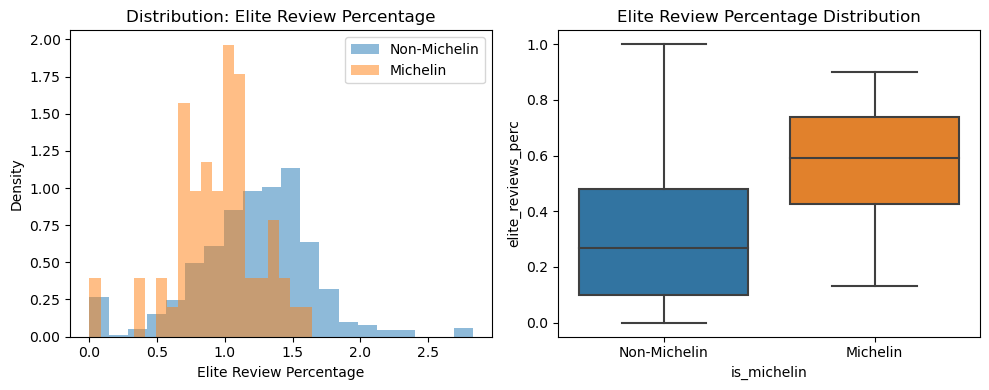

In [48]:
michelin_feature = df_final[df_final['is_michelin']==1]['rating_std']
nonmichelin_feature = df_final[df_final['is_michelin']==0]['rating_std']

plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.hist(x = nonmichelin_feature, bins = 20, density = True, alpha=0.5, label = "Non-Michelin")
plt.hist(x = michelin_feature, bins = 20, density = True, alpha=0.5, label = "Michelin")
plt.ylabel("Density")
plt.xlabel("Elite Review Percentage")
plt.title("Distribution: Elite Review Percentage")
plt.legend()

plt.subplot(1,2,2)
# plt.boxplot([michelin_feature, nonmichelin_feature], labels=['Michelin', 'Non-Michelin'])
sns.boxplot(x='is_michelin', y='elite_reviews_perc', data=df_final)
plt.xticks([0, 1], ['Non-Michelin', 'Michelin'])
plt.title('Elite Review Percentage Distribution')

plt.tight_layout()
plt.show()

## 5 Price Level Comparison

In [49]:
df_final['price'] = df_final['price'].fillna('Unknown')
df_price = df_final.groupby(['is_michelin', 'price']).size().reset_index(name = 'count')
price_mapping = {'$': r'\$', '$$': r'\$\$', '$$$': r'\$\$\$', '$$$$': r'\$\$\$\$', 'Unknown': 'Unknown'}
df_price['price'] = df_price['price'].map(price_mapping)
df_price = df_price.set_index('price')
df_price

,is_michelin,count
price,,
\$,0,2033
\$\$,0,3517
\$\$\$,0,706
\$\$\$\$,0,222
Unknown,0,4337
\$\$,1,1
\$\$\$,1,3
\$\$\$\$,1,45
Unknown,1,13


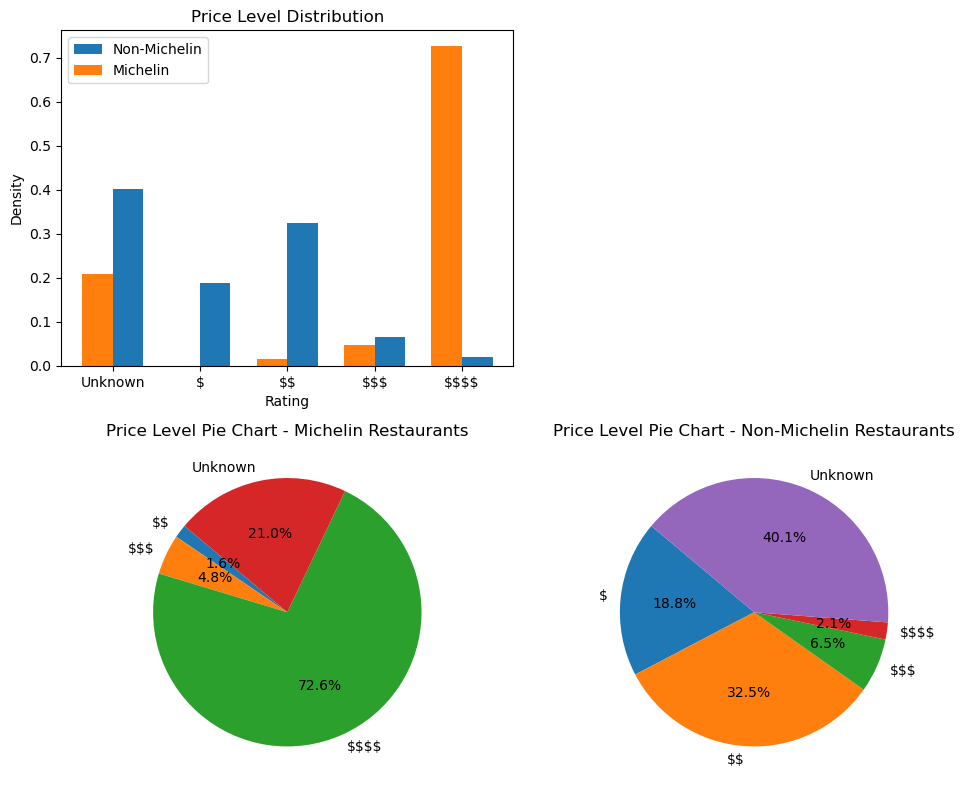

In [50]:
labels = ['Unknown', '\$', '\$\$', '\$\$\$', '\$\$\$\$']
bar_width = 0.35
# Positions of bars on the x-axis
x = np.arange(len(labels))

michelin_feature = df_price[df_price['is_michelin']==1]['count']
nonmichelin_feature = df_price[df_price['is_michelin']==0]['count']

michelin_rating = [michelin_feature[i] if i in michelin_feature.index else 0 for i in labels]
nonmichelin_rating = [nonmichelin_feature[i] if i in nonmichelin_feature.index else 0 for i in labels]

michelin_rating = michelin_rating/sum(michelin_rating)
nonmichelin_rating = nonmichelin_rating/sum(nonmichelin_rating)

plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
# Creating the bar plot
plt.bar(x + bar_width/2, nonmichelin_rating, bar_width, label='Non-Michelin')
plt.bar(x - bar_width/2, michelin_rating, bar_width, label='Michelin')

# Adding labels, title, and legend
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Price Level Distribution')
plt.xticks(x, labels)
plt.legend()

plt.subplot(2,2,3)
plt.title("Price Level Pie Chart - Michelin Restaurants")
plt.pie(df_price[df_price['is_michelin']==1]['count'], labels= df_price[df_price['is_michelin']==1].index, autopct='%1.1f%%', startangle=140)

plt.subplot(2,2,4)
plt.title("Price Level Pie Chart - Non-Michelin Restaurants")
plt.pie(df_price[df_price['is_michelin']==0]['count'], labels= df_price[df_price['is_michelin']==0].index, autopct='%1.1f%%', startangle=140)

# Show plot
plt.tight_layout()
plt.show()

## 6 Cuisine Category Analysis

In [51]:
df_category = df_final.groupby(['is_michelin', 'category_0']).size().reset_index(name = 'count')
df_category['perc'] = df_category.groupby('is_michelin').transform(lambda x: x/x.sum())
df_category

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/2911895110.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df_category['perc'] = df_category.groupby('is_michelin').transform(lambda x: x/x.sum())


,is_michelin,category_0,count,perc
0,0,Acai Bowls,5,0.000462
1,0,Afghan,3,0.000277
2,0,African,24,0.002219
3,0,American,230,0.021267
4,0,Argentine,7,0.000647
...,...,...,...,...
235,1,Scandinavian,1,0.016129
236,1,Seafood,2,0.032258
237,1,Spanish,1,0.016129
238,1,Sushi Bars,9,0.145161


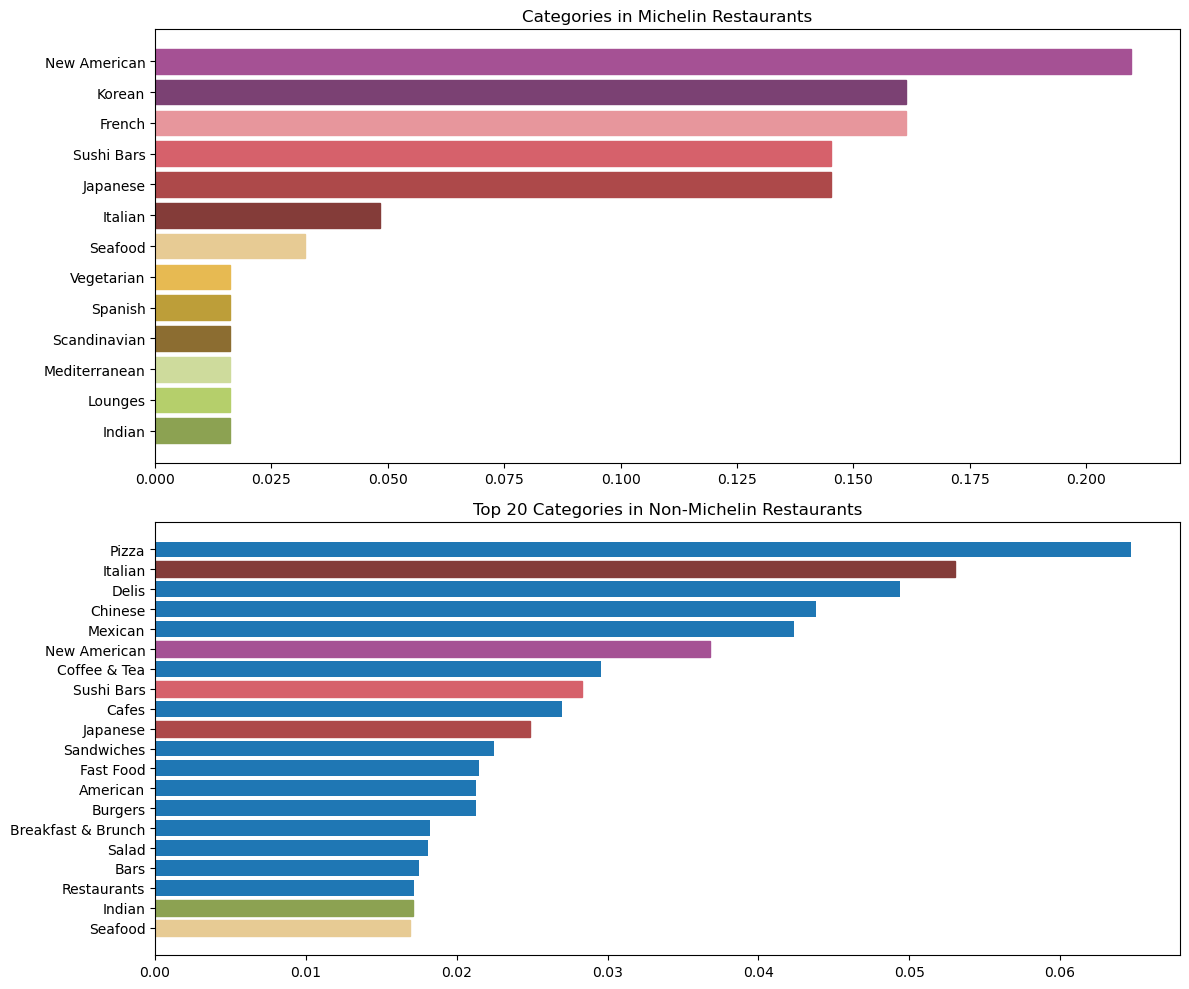

In [52]:
michelin_feature = df_category[df_category['is_michelin']==1].sort_values(by='perc')
nonmichelin_feature = df_category[df_category['is_michelin']==0].sort_values(by='perc')

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
bars = plt.barh(michelin_feature['category_0'], michelin_feature['perc'].values)
plt.title('Categories in Michelin Restaurants')

tab20_cmap = plt.get_cmap('tab20b')
colors = [tab20_cmap(i) for i in range(5, 20)]
color_map = dict(zip(michelin_feature['category_0'], colors))

for i in range(len(bars)):
    name = michelin_feature['category_0'].values[i]
    bars[i].set_color(color_map[name])

plt.subplot(2, 1, 2)
bars = plt.barh(nonmichelin_feature['category_0'][-20:], nonmichelin_feature['perc'].values[-20:])
plt.title('Top 20 Categories in Non-Michelin Restaurants')

for i in range(len(bars)):
    name = nonmichelin_feature['category_0'][-20:].values[i]
    if name in color_map:
        bars[i].set_color(color_map[name])

plt.tight_layout()
plt.show()

## 7 Trend Over Time


In [53]:
df_reviews2 = df_reviews.copy()
df_reviews2 = pd.merge(df_restaurants[['restaurant', 'is_michelin']], df_reviews2, how='inner', on='restaurant')
df_reviews2['localizedDate'] = pd.to_datetime(df_reviews2['localizedDate'])
df_reviews2.set_index('localizedDate', inplace=True)
df_reviews2['year'] = df_reviews2.index.year
df_reviews2['month'] = df_reviews2.index.month

nonmichelin_data = df_reviews2[df_reviews2['is_michelin']==0]
michelin_data = df_reviews2[df_reviews2['is_michelin']==1]

In [54]:
all_trend = df_reviews2.groupby([df_reviews2.index.year, df_reviews2.index.month]).mean().reset_index(drop=True)
nonmichelin_trend = nonmichelin_data.groupby([nonmichelin_data.index.year, nonmichelin_data.index.month]).mean().reset_index(drop=True)
michelin_trend = michelin_data.groupby([michelin_data.index.year, michelin_data.index.month]).mean().reset_index(drop=True)
df_trend = pd.merge(nonmichelin_trend, michelin_trend, on=['year', 'month'], how='outer')[['year', 'month', 'rating_x', 'rating_y']]
df_trend.columns = ['year', 'month', 'NonMichelin_rating','Michelin_rating']
df_trend = pd.merge(df_trend, all_trend, on=['year', 'month'], how='outer')[['year', 'month', 'NonMichelin_rating','Michelin_rating','rating']]


df_reviews_nonmichelin = nonmichelin_data.groupby(['year', 'month']).count()['restaurant'].rename('NonMichelin_review_count').reset_index()
df_reviews_michelin = michelin_data.groupby(['year', 'month']).count()['restaurant'].rename('Michelin_review_count').reset_index()
df_reviews_all = df_reviews2.groupby(['year', 'month']).count()['restaurant'].rename('review_count').reset_index()
df_trend = pd.merge(df_trend, df_reviews_nonmichelin, on=['year', 'month'], how='outer')
df_trend = pd.merge(df_trend, df_reviews_michelin, on=['year', 'month'], how='outer')
df_trend = pd.merge(df_trend, df_reviews_all, on=['year', 'month'], how='outer')
df_trend

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/2950947983.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_trend = df_reviews2.groupby([df_reviews2.index.year, df_reviews2.index.month]).mean().reset_index(drop=True)
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/2950947983.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nonmichelin_trend = nonmichelin_data.groupby([nonmichelin_data.index.year, nonmichelin_data.index.month]).mean().reset_index(drop=True)
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/2950947983.py:3: FutureWarning: The default 

,year,month,NonMichelin_rating,Michelin_rating,rating,NonMichelin_review_count,Michelin_review_count,review_count
0,2005.0,5.0,3.333333,NaN,3.333333,3,NaN,3
1,2005.0,6.0,3.500000,NaN,3.500000,2,NaN,2
2,2005.0,7.0,2.500000,NaN,2.500000,4,NaN,4
3,2005.0,8.0,2.000000,NaN,2.000000,1,NaN,1
4,2005.0,9.0,2.800000,NaN,2.800000,5,NaN,5
...,...,...,...,...,...,...,...,...
218,2023.0,7.0,3.986861,4.468571,3.993644,12254,175.0,12429
219,2023.0,8.0,4.003907,4.307692,4.007716,12285,156.0,12441
220,2023.0,9.0,4.017370,4.300000,4.021440,12320,180.0,12500
221,2023.0,10.0,4.034415,4.362445,4.039791,13744,229.0,13973


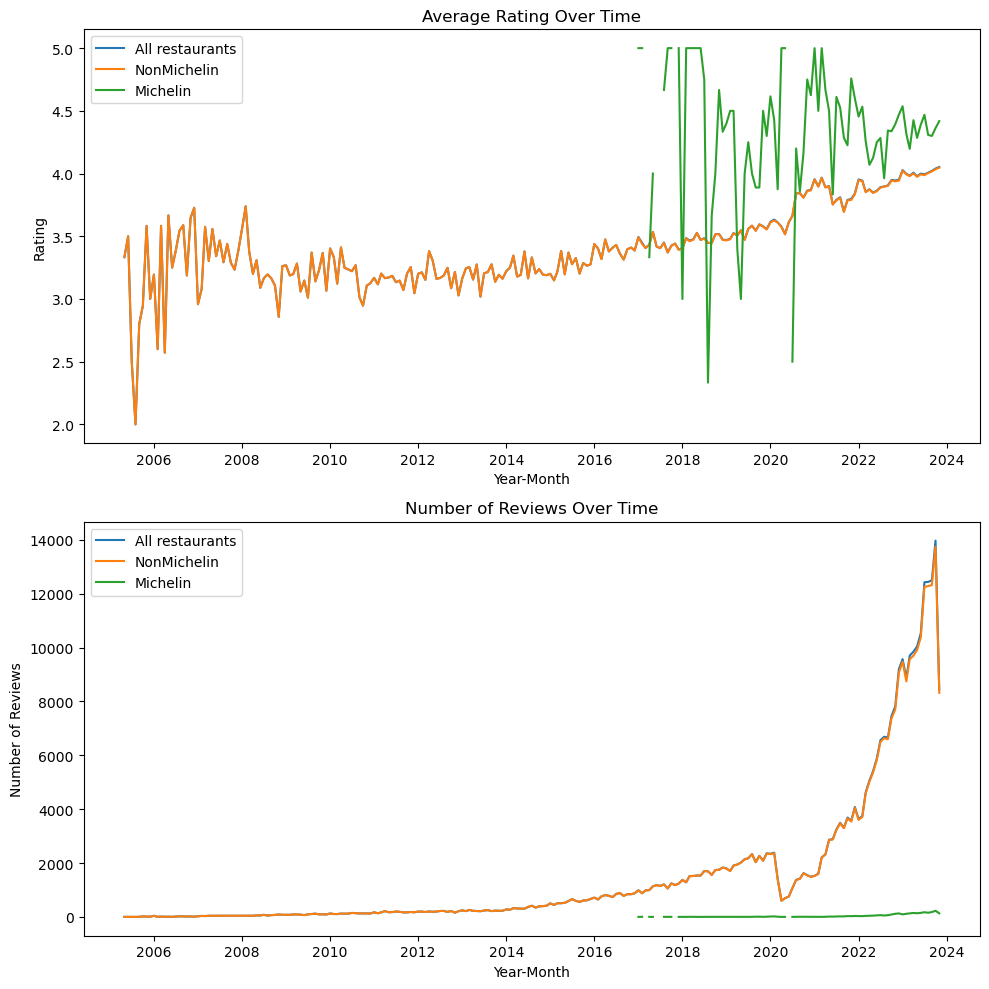

In [55]:
df_trend['year-month'] = pd.to_datetime(df_trend[['year', 'month']].assign(day=1))

# Plotting
plt.figure(figsize=(10, 10))

# Plot: average rating over time
plt.subplot(2,1,1)
plt.plot(df_trend['year-month'], df_trend['rating'], label='All restaurants')
plt.plot(df_trend['year-month'], df_trend['NonMichelin_rating'], label='NonMichelin')
plt.plot(df_trend['year-month'], df_trend['Michelin_rating'], label='Michelin')

plt.title('Average Rating Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Rating')
plt.legend()

# Plot: number of reviews over time
plt.subplot(2,1,2)
plt.plot(df_trend['year-month'], df_trend['review_count'], label='All restaurants')
plt.plot(df_trend['year-month'], df_trend['NonMichelin_review_count'], label='NonMichelin')
plt.plot(df_trend['year-month'], df_trend['Michelin_review_count'], label='Michelin')

plt.title('Number of Reviews Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend()

plt.tight_layout()
plt.show()

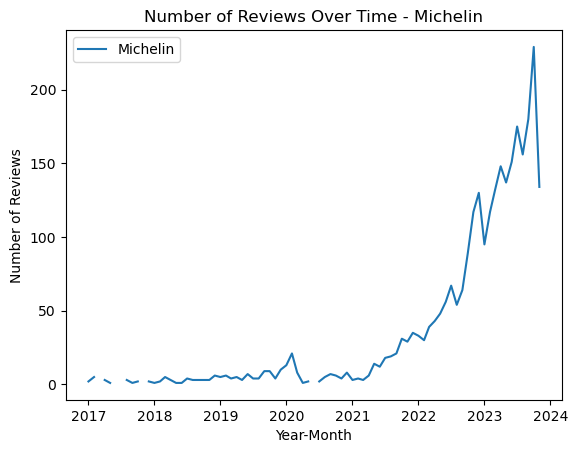

In [56]:

plt.plot(df_trend['year-month'], df_trend['Michelin_review_count'], label='Michelin')
plt.title('Number of Reviews Over Time - Michelin')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend()

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/1643197049.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_by_weekday = df_reviews2.groupby(df_reviews2.index.dayofweek).mean()['rating']
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/1643197049.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_by_weekday = nonmichelin_data.groupby(nonmichelin_data.index.dayofweek).mean()['rating']
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/1643197049.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a futur

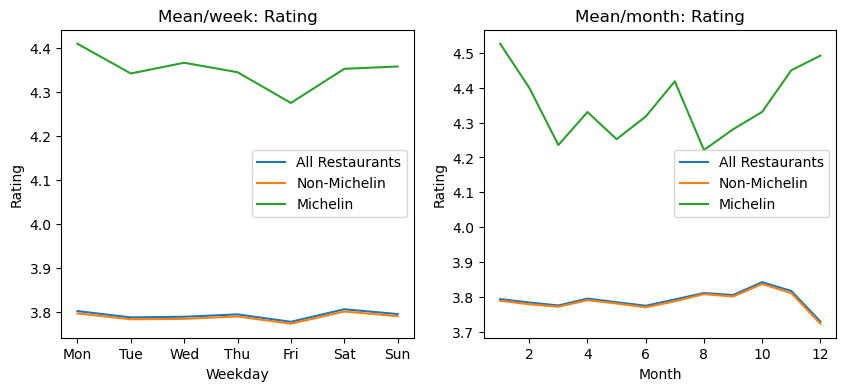

In [57]:
plt.figure(figsize=(10, 4))
# Average rating for each month of the year
plt.subplot(1,2,1)
avg_by_weekday = df_reviews2.groupby(df_reviews2.index.dayofweek).mean()['rating']
avg_by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_by_weekday.plot(label='All Restaurants')

avg_by_weekday = nonmichelin_data.groupby(nonmichelin_data.index.dayofweek).mean()['rating']
avg_by_weekday.plot(label='Non-Michelin')

avg_by_weekday = michelin_data.groupby(michelin_data.index.dayofweek).mean()['rating']
avg_by_weekday.plot(label='Michelin')

plt.xlabel('Weekday')
plt.ylabel('Rating')
plt.title('Mean/week: Rating')
plt.legend()

# Average rating for each weekday of the week
plt.subplot(1,2,2)
avg_by_weekday = df_reviews2.groupby(df_reviews2.index.month).mean()['rating']
avg_by_weekday.plot(label='All Restaurants')

avg_by_weekday = nonmichelin_data.groupby(nonmichelin_data.index.month).mean()['rating']
avg_by_weekday.plot(label='Non-Michelin')

avg_by_weekday = michelin_data.groupby(michelin_data.index.month).mean()['rating']
avg_by_weekday.plot(label='Michelin')

plt.xlabel("Month")
plt.ylabel('Rating')
plt.title('Mean/month: Rating')
plt.legend()
plt.show()

## 8 Elite vs Non-Elite

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/3131967923.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bar_plot = df_elite.groupby(['is_elite', 'is_michelin']).mean()['rating'].plot(kind='bar', ax=ax1)
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/3131967923.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bar_plot = df_elite.groupby(['is_elite']).mean()[['photoCount', 'reviewCount']].plot(kind='bar', ax=ax2)


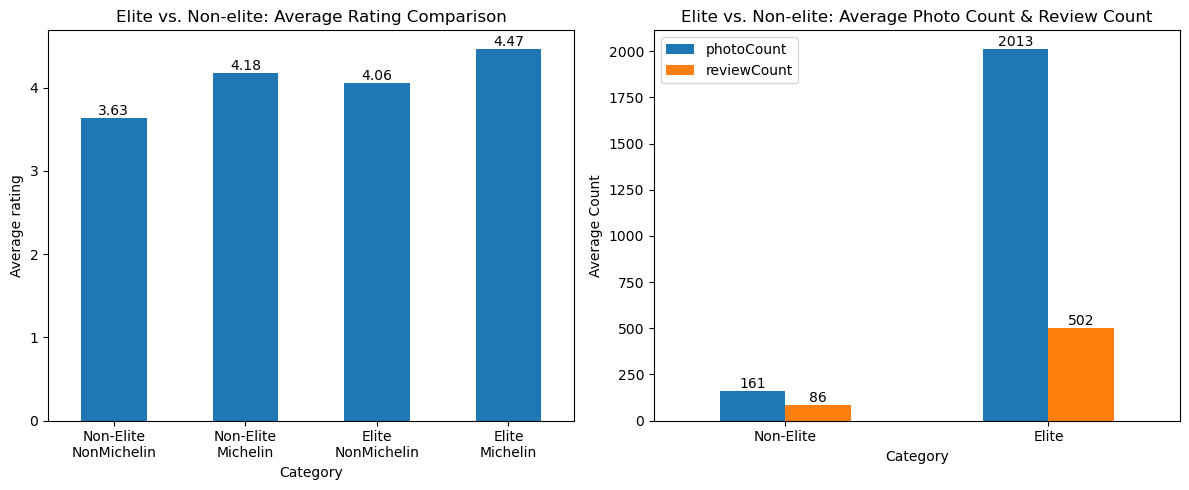

In [58]:
df_elite = df_reviews.copy()
df_elite = pd.merge(df_restaurants[['restaurant', 'is_michelin']], df_elite, how='inner', on='restaurant')
df_elite['is_elite'] = ~df_elite['eliteYear'].isna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elite vs. Non-elite: Average rating comparison
bar_plot = df_elite.groupby(['is_elite', 'is_michelin']).mean()['rating'].plot(kind='bar', ax=ax1)
ax1.set_xticklabels(['Non-Elite\nNonMichelin', 'Non-Elite\nMichelin', 'Elite\nNonMichelin', 'Elite\nMichelin'], rotation=0)
ax1.set_xlabel('Category')
ax1.set_ylabel('Average rating')
# Annotate each bar with its value
for p in bar_plot.patches:
    bar_plot.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 5), textcoords='offset points')
ax1.set_title("Elite vs. Non-elite: Average Rating Comparison")

# Elite vs. Non-elite: Average photoCount & reviewCount
bar_plot = df_elite.groupby(['is_elite']).mean()[['photoCount', 'reviewCount']].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(['Non-Elite', 'Elite'], rotation=0)
ax2.set_xlabel('Category')
ax2.set_ylabel('Average Count')
ax2.set_title("Elite vs. Non-elite: Average Photo Count & Review Count")
# Annotate each bar with its value
for p in bar_plot.patches:
    bar_plot.annotate(str(round(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## Classification

In [104]:
# pick some significant features to do the classification
df_classification = df_final[['is_michelin', 'rating', 'review_count', 'category_0', 'price', 'coordinates.latitude', 'coordinates.longitude', 'elite_reviews_perc', 'user_photo_cnt_avg', 'user_review_cnt_avg', 'rating_std']]
df_classification

,is_michelin,rating,review_count,category_0,price,coordinates.latitude,coordinates.longitude,elite_reviews_perc,user_photo_cnt_avg,user_review_cnt_avg,rating_std
0,0,3.0,84,Coffee & Tea,$$,40.7113,-74.016193,0.320000,755.900000,199.860000,1.531173
1,0,2.5,19,Creperies,$,40.711547,-74.0154,0.052632,654.894737,244.842105,1.300022
2,0,3.5,132,Mexican,$$,40.712342,-74.01528,0.480000,3183.000000,365.740000,1.159873
3,0,3.0,333,Burgers,$$,40.712344,-74.015511,0.680000,941.800000,424.520000,1.378553
4,0,4.5,32,Mediterranean,Unknown,40.71156,-74.01533,0.468750,603.875000,252.406250,1.077632
...,...,...,...,...,...,...,...,...,...,...,...
10872,0,4.0,228,Korean,$$,40.818781,-73.976895,0.560000,979.220000,312.580000,1.143036
10873,0,4.0,94,Japanese,$$,40.83173,-73.972651,0.320000,609.660000,186.440000,1.195229
10874,0,2.0,6,Chinese,Unknown,40.825358,-73.92594,0.000000,1.833333,5.833333,1.834848
10875,0,2.5,18,Pizza,$$,40.826923,-73.926337,0.055556,3847.222222,312.888889,1.685191


In [105]:
df_classification['coordinates.latitude'] = pd.to_numeric(df_classification['coordinates.latitude'])
df_classification['coordinates.longitude']= pd.to_numeric(df_classification['coordinates.longitude'])
# check na
df_classification.isna().sum()

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/1782251513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['coordinates.latitude'] = pd.to_numeric(df_classification['coordinates.latitude'])
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/1782251513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['coordinates.longitude']= pd.to_numeric(df_classification['coordinates.longitude'])


is_michelin                 0
rating                      0
review_count                0
category_0                  0
price                       0
coordinates.latitude        1
coordinates.longitude       1
elite_reviews_perc          0
user_photo_cnt_avg          0
user_review_cnt_avg         0
rating_std               1003
dtype: int64

In [106]:
# fill NAs
df_classification['rating_std'] = df_classification['rating_std'].fillna(0) # if we only get one review, then the std should be 0
df_classification['coordinates.latitude'] = df_classification['coordinates.latitude'].fillna(df_classification['coordinates.latitude'].mean())
df_classification['coordinates.longitude'] = df_classification['coordinates.longitude'].fillna(df_classification['coordinates.longitude'].mean())

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/814217125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['rating_std'] = df_classification['rating_std'].fillna(0) # if we only get one review, then the std should be 0
/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/814217125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['coordinates.latitude'] = df_classification['coordinates.latitude'].fillna(df_classification['coordinates.lati

/var/folders/gb/wrpqbk497hs6zmqgnpmffmqh0000gn/T/ipykernel_60481/738852501.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_classification.corr()


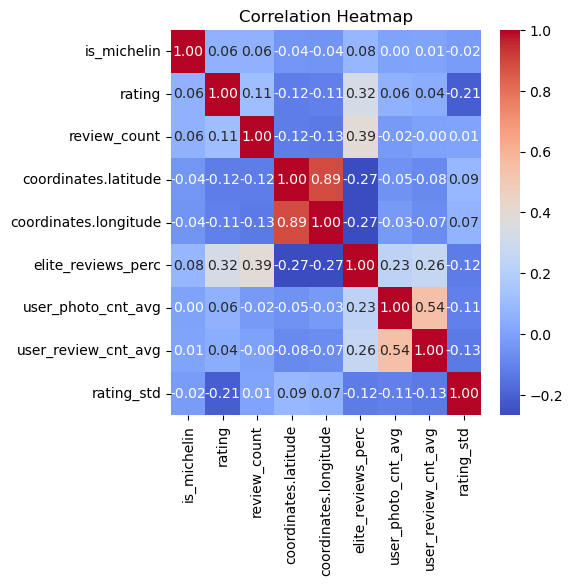

In [107]:
corr_matrix = df_classification.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Although the coordinates.latitude and coordinates.longitude are highly correlated, we know that they captures different features of the location, so we keep these 2 features. Since 'user_photo_cnt_avg' & 'user_review_cnt_avg' have relatively high correlation (0.54), we drop one of them ('user_photo_cnt_avg').

In [108]:
df_classification = df_classification.drop('user_photo_cnt_avg', axis=1)

In [109]:
df_encoded = pd.get_dummies(df_classification, drop_first=True)
X = df_encoded.drop('is_michelin', axis=1)
y = df_encoded['is_michelin']

# imbalanced data
y.value_counts()

0    10815
1       62
Name: is_michelin, dtype: int64

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Shape of Training Data:", X_train.shape)
print("Shape of Test Data:", X_test.shape)

Shape of Training Data: (8157, 237)
Shape of Test Data: (2720, 237)


When we try to use a usual classifier to classify an imbalanced dataset, the model favors the majority class due to its larger volume presence. A BalancedBaggingClassifier is the same as a sklearn classifier but with additional balancing. It includes an additional step to balance the training set at the time of fit for a given sampler. This classifier takes two special parameters “sampling_strategy” and “replacement”. The sampling_strategy decides the type of resampling required (e.g. ‘majority’ – resample only the majority class, ‘all’ – resample all classes, etc) and replacement decides whether it is going to be a sample with replacement or not.

In [111]:
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)

/Users/dai/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


In [112]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2704
           1       0.17      0.06      0.09        16

    accuracy                           0.99      2720
   macro avg       0.58      0.53      0.54      2720
weighted avg       0.99      0.99      0.99      2720



In [114]:
pd.DataFrame(preds).value_counts()

0    2714
1       6
dtype: int64

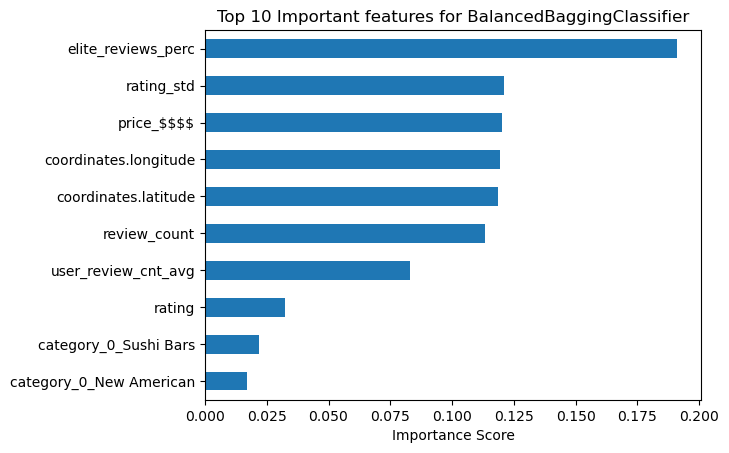

In [118]:
# the mean importance across the estimators
feature_importance = np.mean([est.steps[1][1].feature_importances_ for est in classifier.estimators_], axis=0)
price_mapping = {'price_$$': r'price_\$\$', 'price_$$$': r'price_\$\$\$', 'price_$$$$': r'price_\$\$\$\$'}
features = [price_mapping[i] if i in price_mapping.keys() else i for i in X.columns]
pd.Series(feature_importance, index=features).nlargest(10)[::-1].plot(kind='barh')
plt.xlabel("Importance Score")
plt.title("Top 10 Important features for BalancedBaggingClassifier")
plt.show()